# Sentiment Analysis
We will perform Sentiment Analysis on the [Sentiment140](https://www.kaggle.com/datasets/kazanova/sentiment140/) dataset.

## Import Dependencies

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [302]:
import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)
import sys
sys.version

Num GPUs Available:  0
2.14.0


'3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]'

# 1. Import Data
The Sentiment140 dataset is a collection of 1,600,000 tweets from twitter. The tweets have been annotated (0 = negative, 4 = positive)

In [257]:
# NOTE: change destination folder of dataset to suit.
sentiment140_data = pd.read_csv("datasets/training.1600000.processed.noemoticon.csv", 
                                encoding="ISO-8859-1", header=None, names=["target","id","date","flag","user","text"])

In [258]:
sentiment140_data

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


### Drop columns that arent needed

In [259]:
data = sentiment140_data.drop(["id","date","flag","user"], axis=1)

In [260]:
data

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [261]:
data.isnull().any()

target    False
text      False
dtype: bool

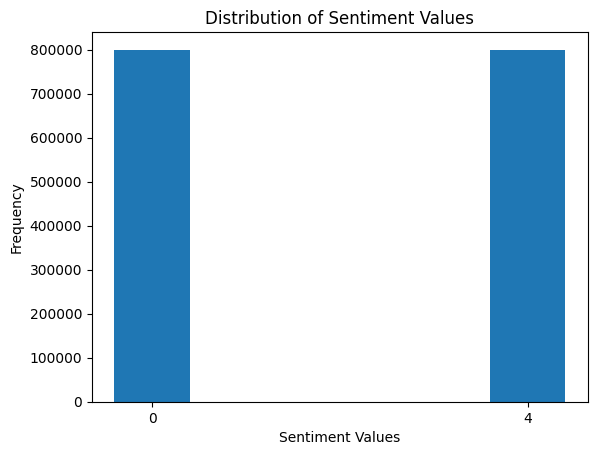

In [262]:
# Bar chart to check for data imbalance.
value_counts = data["target"].value_counts()
plt.bar(value_counts.index, value_counts.values)
plt.xlabel("Sentiment Values")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiment Values")
plt.xticks(value_counts.index)
plt.show()

### Convert sentiment target values from integer to string

In [263]:
LABEL_MAP = {0:"Negative", 2:"Neutral", 4:"Positive"}
def label_decoder(label):
    return LABEL_MAP[label]

In [264]:
data.target = data.target.apply(lambda x: label_decoder(x))
data

,target,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,Positive,Just woke up. Having no school is the best fee...
1599996,Positive,TheWDB.com - Very cool to hear old Walt interv...
1599997,Positive,Are you ready for your MoJo Makeover? Ask me f...
1599998,Positive,Happy 38th Birthday to my boo of alll time!!! ...


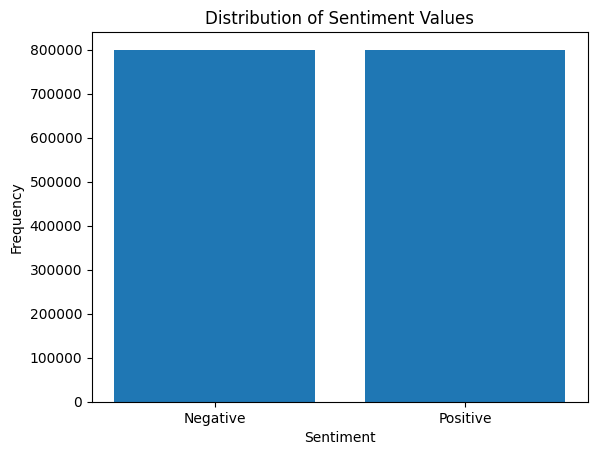

In [265]:
value_counts = data["target"].value_counts()
plt.bar(value_counts.index, value_counts.values)
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiment Values")
plt.xticks(value_counts.index)
plt.show()

## Data Preprocessing

In [266]:
nltk.download('stopwords', quiet=True)

True

In [267]:
# TODO: handle emojis if time
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
TEXT_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [268]:
def preprocess(text, stem=False):
    text = re.sub(TEXT_RE, " ", str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [269]:
data["text"] = data["text"].apply(lambda x: preprocess(x))
data.head()

,target,text
0,Negative,awww bummer shoulda got david carr third day
1,Negative,upset update facebook texting might cry result...
2,Negative,dived many times ball managed save 50 rest go ...
3,Negative,whole body feels itchy like fire
4,Negative,behaving mad see


In [270]:
count=0
for row in data.itertuples():
    print("Text:", row[2])
    count+=1
    if count>10:
        break

Text: awww bummer shoulda got david carr third day
Text: upset update facebook texting might cry result school today also blah
Text: dived many times ball managed save 50 rest go bounds
Text: whole body feels itchy like fire
Text: behaving mad see
Text: whole crew
Text: need hug
Text: hey long time see yes rains bit bit lol fine thanks
Text: nope
Text: que muera
Text: spring break plain city snowing


## Train Test Split

In [285]:
TRAIN_SIZE = 0.8
X = np.array(data["text"])
y = np.array(data["target"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-TRAIN_SIZE, random_state=42)

print("X_train Size:", len(X_train))
print("X_test Size:", len(X_test))

X_train Size: 1280000
X_test Size: 320000


In [286]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

## Feature Extraction

### TF-IDF

In [18]:
NGRAM_RANGE = (1,2)
#MAX_FEATURES = 50000
tfidf = TfidfVectorizer(ngram_range=NGRAM_RANGE)

In [21]:
tfidf.fit(X_train)

X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

len(tfidf.idf_)

# Embeddings - Word2Vec

In [287]:
from gensim.models import Word2Vec

embedding_dimensions = 100

Word2Vec_train_data = list(map(lambda x: x.split(), X_train))

In [289]:
%%time

# Train word2vec model
word2vec_model = Word2Vec(Word2Vec_train_data,
                 vector_size=embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 48146
CPU times: total: 2min 12s
Wall time: 29.3 s


## Tokenizing and Padding

In [290]:
#Model input length
input_length = 60
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 60000


In [291]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)



X_train.shape: (1280000, 60)
X_test.shape : (320000, 60)


## Embedding Matrix

In [292]:
embedding_matrix = np.zeros((vocab_length, embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (60000, 100)


# Machine Learning Models

## Support Vector Machine

## Long Short-Term Memory Network

In [293]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [325]:
def LSTM_Model(embedding_layer):
    model = Sequential(name="Full_LSTM_Model")
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)))
    model.add(Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)))
    model.add(Conv1D(100,5,activation='relu'))
    model.add(GlobalMaxPool1D())
    model.add(Dense(16,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))

    print(model.summary())

    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(
        X_train, y_train_encoded,
        batch_size=1024,
        epochs=12,
        validation_split=0.1,
        callbacks=callbacks,
        verbose=1,
    )
    
    return (model, history)

In [326]:
embedding_layer = Embedding(input_dim = vocab_length,
                            output_dim = embedding_dimensions,
                            weights=[embedding_matrix],
                            input_length=input_length,
                            trainable=False)

model, history = LSTM_Model(embedding_layer)

Model: "Full_LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 60, 100)           6000000   
                                                                 
 bidirectional_46 (Bidirect  (None, 60, 200)           160800    
 ional)                                                          
                                                                 
 bidirectional_47 (Bidirect  (None, 60, 200)           240800    
 ional)                                                          
                                                                 
 conv1d_23 (Conv1D)          (None, 56, 100)           100100    
                                                                 
 global_max_pooling1d_25 (G  (None, 100)               0         
 lobalMaxPooling1D)                                              
                                                   

# Evaluating the models

### Save/Load Models (optional)

In [327]:
model.save('LSTM_model.keras')


In [315]:
# del model

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("LSTM_model.keras")
model.summary()

### Learning Curves - Loss and Accuracy

In [328]:
def lossAndAccuracy(hist, title):
    acc,  val_acc  = hist.history['accuracy'], hist.history['val_accuracy']
    loss, val_loss = hist.history['loss'], hist.history['val_loss']
    epochs = range(len(acc))

    plt.suptitle(title)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

### Confusion Matrix

In [329]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def confusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### LSTM Evaluation

<Figure size 640x480 with 0 Axes>

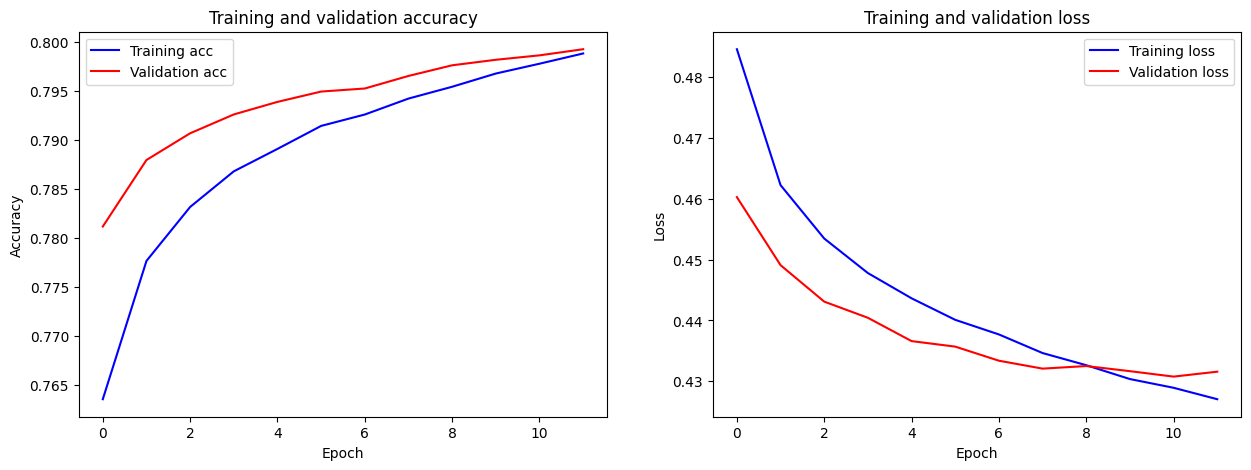

In [330]:
lossAndAccuracy(history, "LSTM_Model")

In [331]:
# Predicting on the Test dataset.
y_pred = model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)



10000/10000 [==============================] - 640s 64ms/step


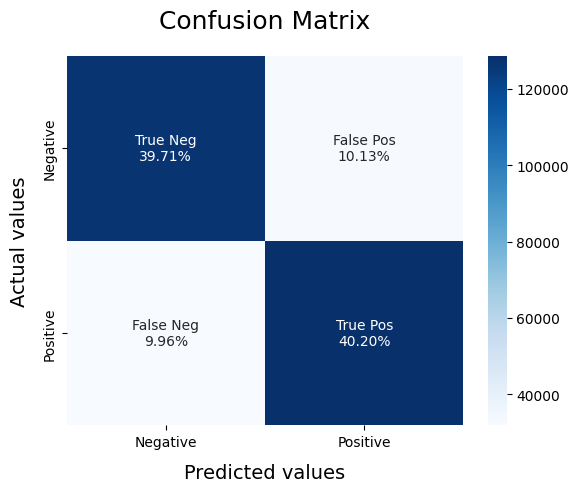

In [334]:
# Printing out the Evaluation metrics. 
confusionMatrix(y_pred, y_test_encoded)

In [335]:
print(classification_report(y_pred, y_test_encoded))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80    158931
           1       0.80      0.80      0.80    161069

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000

